In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
df = pd.read_csv('Airlines_Data.csv', parse_dates = ['Month'], index_col = ['Month'])
df.head(10)

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
1995-06-01,135
1995-07-01,148
1995-08-01,148
1995-09-01,136


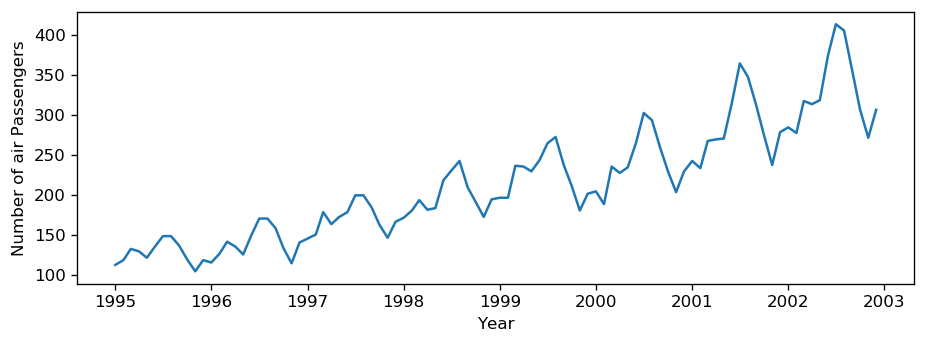

In [19]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
plt.xlabel('Year')
plt.ylabel('Number of air Passengers')
plt.plot(df)

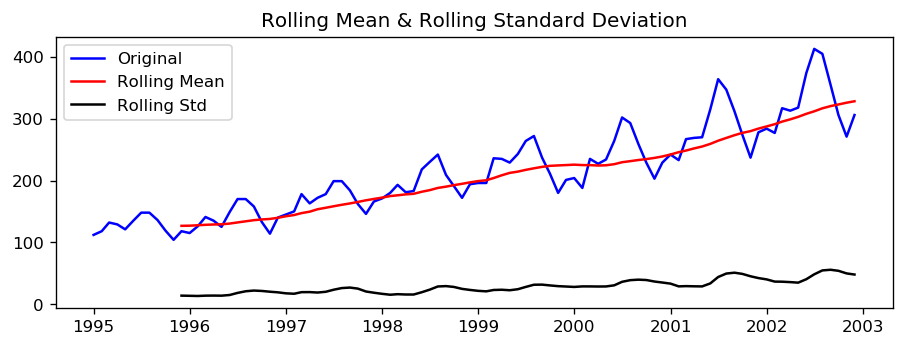

In [7]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [8]:
result = adfuller(df['Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 1.3402479596467036
p-value: 0.9968250481137263
Critical Values:
	1%: -3.5117123057187376
	5%: -2.8970475206326833
	10%: -2.5857126912469153


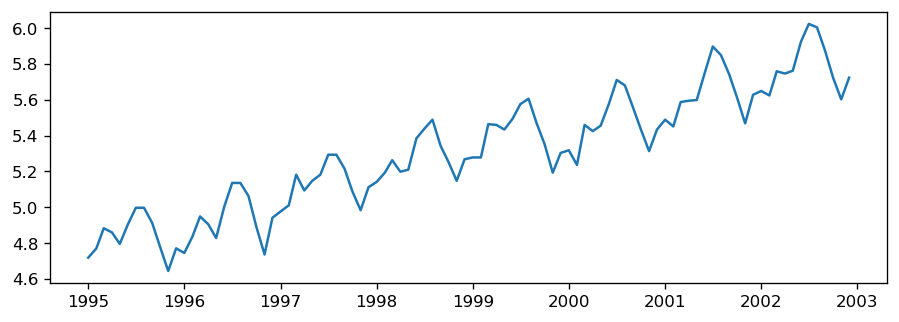

In [9]:
df_log = np.log(df)
plt.plot(df_log)
plt.show()

In [11]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Passengers'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

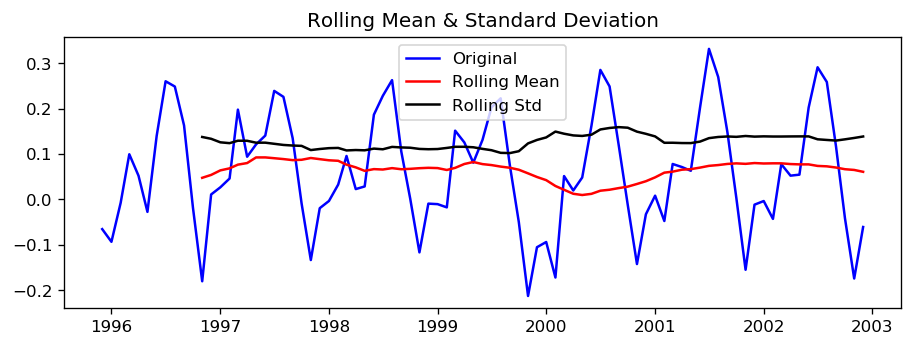

ADF Statistic: -1.9109302496441956
p-value: 0.3269367761072137
Critical Values:
	1%: -3.524624466842421
	5%: -2.9026070739026064
	10%: -2.5886785262345677


In [12]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean)

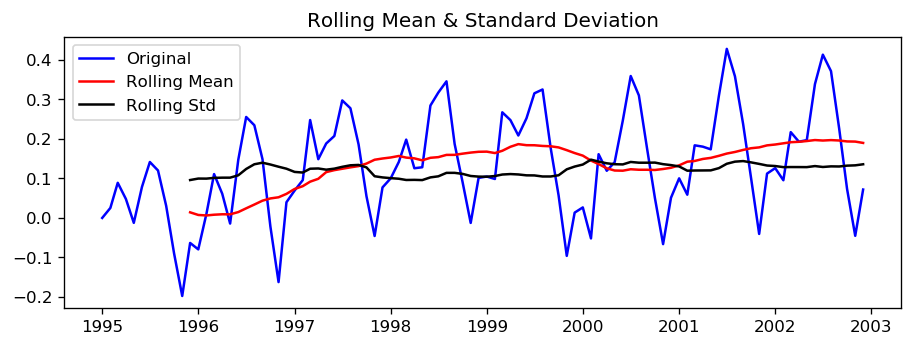

ADF Statistic: -2.8350363324812933
p-value: 0.05344073374466739
Critical Values:
	1%: -3.5117123057187376
	5%: -2.8970475206326833
	10%: -2.5857126912469153


In [13]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

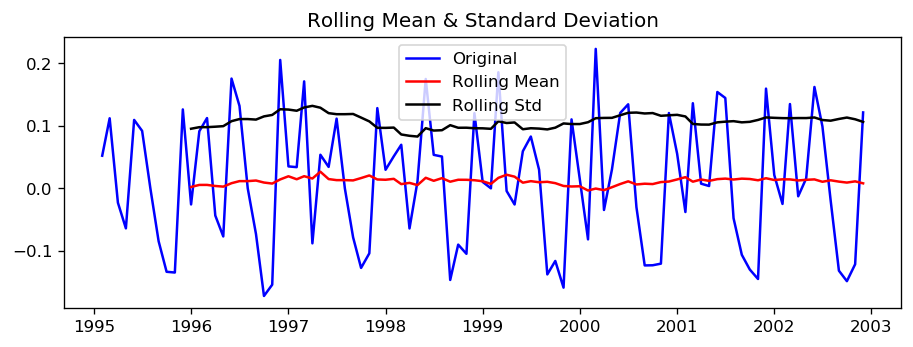

ADF Statistic: -2.6708228902694557
p-value: 0.07922469056629483
Critical Values:
	1%: -3.512738056978279
	5%: -2.8974898650628984
	10%: -2.585948732897085


In [14]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


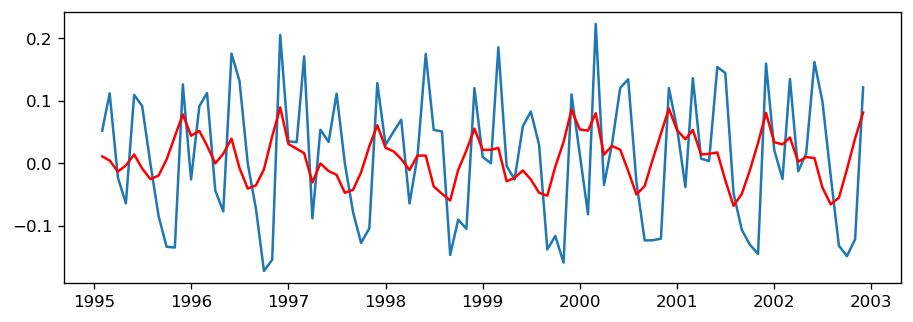

In [15]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(1,1,1))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

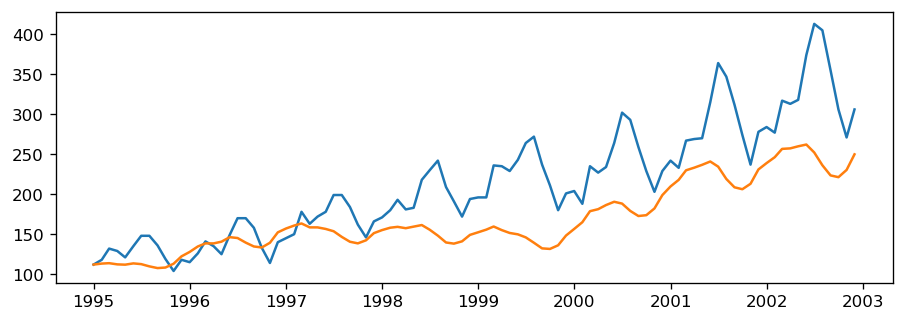

In [17]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

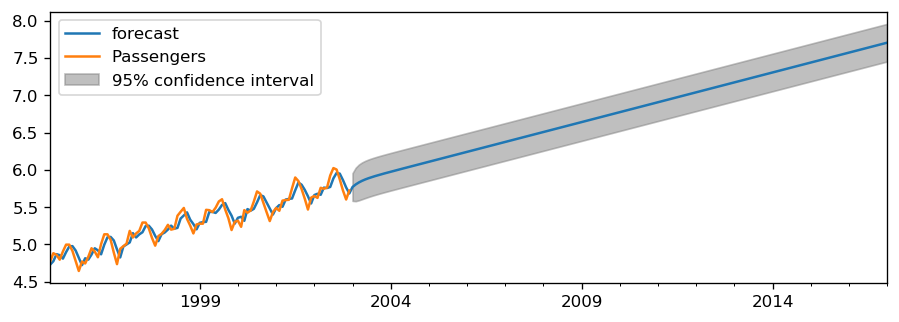

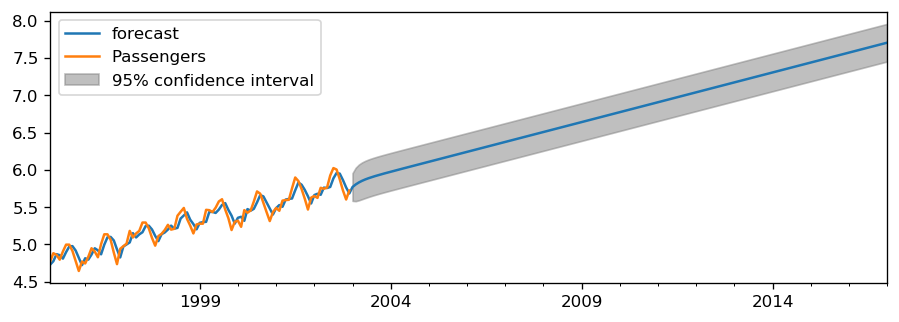

In [18]:
results.plot_predict(1,264)